# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [257]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import time

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [258]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [259]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [260]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [261]:
azdias.isnull().sum().sort_values(ascending=False)

KK_KUNDENTYP             584612
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
MOBI_REGIO               133324
REGIOTYP                 121196
KKK                      121196
PLZ8_ANTG3               116515
PLZ8_ANTG1               116515
PLZ8_GBZ                 116515
PLZ8_ANTG2               116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
ORTSGR_KLS9               97216
ARBEIT                    97216
RELAT_AB                  97216
ANZ_HH_TITEL              97008
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDETYP_RASTER        93155
                          ...  
FINANZ_H

In [262]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [263]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ALTERSKATEGORIE_GROB,person,ordinal,[-1]
freq,1,43,49,26


In [264]:
feat_info.isnull().sum().sort_values(ascending=False)

missing_or_unknown    0
type                  0
information_level     0
attribute             0
dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [265]:
# Identify missing or unknown data values and convert them to NaNs.
# Convert the 'missing_or_unknown' col of feat_info to a list
if type(feat_info['missing_or_unknown'].values[0]) == str:
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.replace('[', '').replace(']', '').split(','))
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [266]:
# use feat_info as dict
feat_dict = feat_info.set_index('attribute').to_dict(orient='dict')
def nan_fill(x, col):
    if str(x) in feat_dict['missing_or_unknown'][col]:
        return np.nan
    return x

In [267]:
x = 1
for col in azdias.columns:
    azdias[col] = azdias[col].apply(lambda x: nan_fill(x, col))
    print('processed ' + str(x) + ' of ' + str(len(azdias.columns)))
    x+=1

processed 1 of 85
processed 2 of 85
processed 3 of 85
processed 4 of 85
processed 5 of 85
processed 6 of 85
processed 7 of 85
processed 8 of 85
processed 9 of 85
processed 10 of 85
processed 11 of 85
processed 12 of 85
processed 13 of 85
processed 14 of 85
processed 15 of 85
processed 16 of 85
processed 17 of 85
processed 18 of 85
processed 19 of 85
processed 20 of 85
processed 21 of 85
processed 22 of 85
processed 23 of 85
processed 24 of 85
processed 25 of 85
processed 26 of 85
processed 27 of 85
processed 28 of 85
processed 29 of 85
processed 30 of 85
processed 31 of 85
processed 32 of 85
processed 33 of 85
processed 34 of 85
processed 35 of 85
processed 36 of 85
processed 37 of 85
processed 38 of 85
processed 39 of 85
processed 40 of 85
processed 41 of 85
processed 42 of 85
processed 43 of 85
processed 44 of 85
processed 45 of 85
processed 46 of 85
processed 47 of 85
processed 48 of 85
processed 49 of 85
processed 50 of 85
processed 51 of 85
processed 52 of 85
processed 53 of 85
pr

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

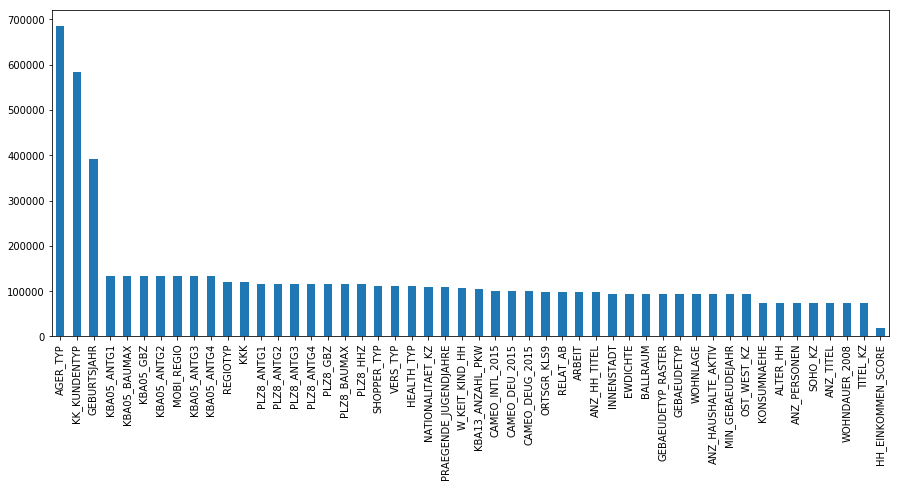

In [268]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum().sort_values(ascending = False)[:50].plot(kind='bar', figsize=(15, 6));

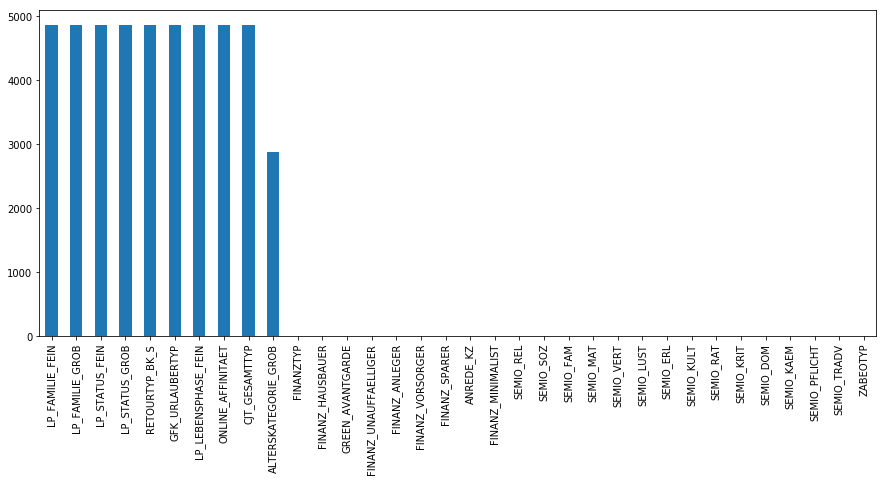

In [269]:
# missing fewer values
azdias.isnull().sum().sort_values(ascending = False)[51:].plot(kind='bar', figsize=(15, 6));

In [270]:
# Investigate patterns in the amount of missing data in each column.
hit_or_miss = feat_info[feat_info['attribute'].isin(azdias.isnull().sum().sort_values(ascending=False).index.tolist())]
if 'missing' not in hit_or_miss.columns:
    hit_or_miss = hit_or_miss.merge(azdias.isnull().sum().rename('missing'), how='left', left_on='attribute', right_index=True)
hit_or_miss.sort_values(by = 'missing', ascending = False, inplace=True)
hit_or_miss.head()

,attribute,information_level,type,missing_or_unknown,missing
0,AGER_TYP,person,categorical,"[-1, 0]",685843
47,KK_KUNDENTYP,household,categorical,[-1],584612
11,GEBURTSJAHR,person,numeric,[0],392318
60,KBA05_ANTG1,microcell_rr3,ordinal,[-1],133324
61,KBA05_ANTG2,microcell_rr3,ordinal,[-1],133324


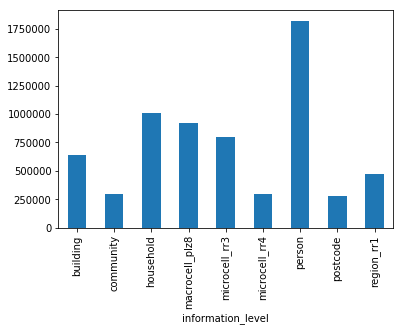

In [271]:
hit_or_miss.groupby('information_level')['missing'].sum().plot(kind='bar');

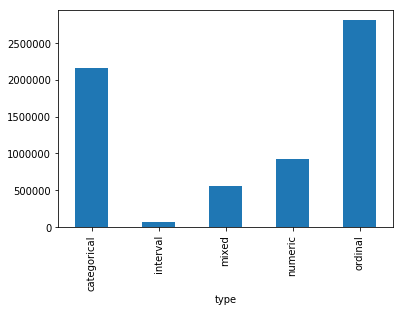

In [272]:
hit_or_miss.groupby('type')['missing'].sum().plot(kind='bar');

### 1.1. AGER_TYP
Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly

### 2.5. KK_KUNDENTYP
Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer

### 1.7. GEBURTSJAHR
Year of birth
- missing data encoded as 0

In [273]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
nan_outliers = azdias.isnull().sum().sort_values(ascending=False)[:3].index.tolist()
df = azdias.drop(columns = nan_outliers)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

report your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?

<font color='blue'> I removed 3 columns, those being AGER_TYP, KK_KUNDERNTYP, and GEBURTSJAHR. The overall pattern in missing values is that the dataset is missing person and ordinal/categorical values - however, the columns I've chosen to remove are two personal and one household column, and two categorical and one numeric column.<font>
    
<font color='blue'> As for the data explicitly contained in the columns, we are missing values detailing the type of elderly person (unsure what it means to be passively elderly, culturally elderly, etc) and the year of birth; we are also missing data regarding customer status. It makes sense that we would be missing data on the customer status of the German population as this is a market that we are trying to break into, and it is unlikely that we already have a customer base in that region. I cannot yet explain why we are missing data on the elderly because I do not know how this information was gathered. One possibility is that it was gathered by a self reported census, and elderly folks are less likely to be willing to disclose personal details.<font>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

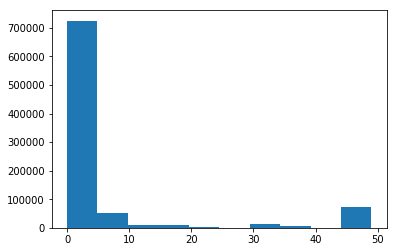

In [274]:
# How much data is missing in each row of the dataset?
df['missing_r'] = df.isnull().sum(axis=1)
plt.hist(df['missing_r']);

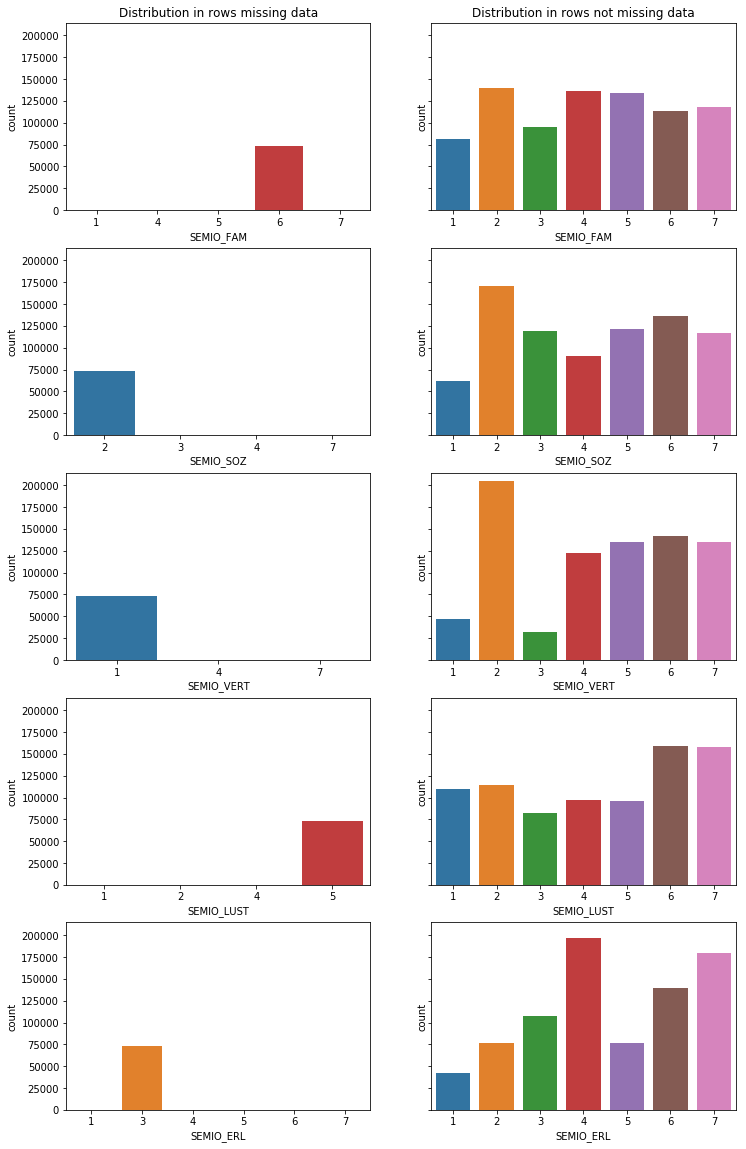

In [275]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_plots(threshold, column_name):
    df_above_thresh = df[df['missing_r'] >= threshold]
    df_below_thresh = df[df['missing_r'] < threshold]
    
    f, axes = plt.subplots(figsize=(12, 4*len(column_name)), sharey=True, ncols = 2, nrows = len(column_name))
    i = 0
    for col in column_name:
        sns.countplot(col, data = df_above_thresh, ax=axes[i][0])
        sns.countplot(col, data = df_below_thresh, ax=axes[i][1])
        i+=1
        
    axes[0][0].set_title('Distribution in rows missing data')
    axes[0][1].set_title('Distribution in rows not missing data')
    
cols_list = ['SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL']
threshold = 40
compare_plots(threshold, cols_list)
df_above_thresh = df[df['missing_r'] >= threshold]
df_below_thresh = df[df['missing_r'] < threshold]

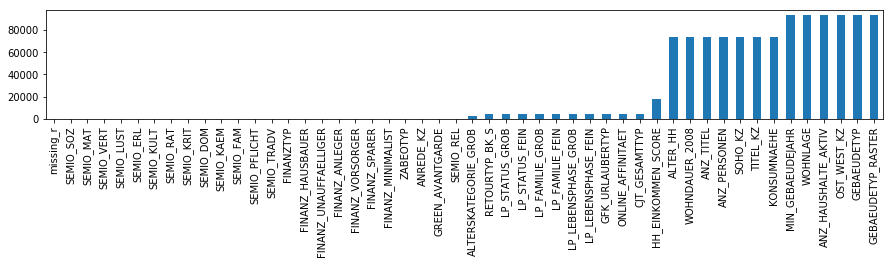

In [276]:
df.isnull().sum().sort_values(ascending = True)[:50].plot(kind='bar', figsize=(15, 2));

In [277]:
# remove rows with significantly high missing data count
df = df[df['missing_r'] < 1]

#### Discussion 1.1.3: Assess Missing Data in Each Row

Report your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?

<font color='blue'>For all 5 of the features selected, the rows which were missing data in other fields represented a dramatically different distribution of values. All 5 shown in fact had all rows in one bin of the feature, as opposed to a more even distribution represented in rows which were not missing other data. They are qualitatively different, however I have removed them from the dataset from the time being in order to continue with the investigation. <font>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [278]:
# How many features are there of each data type?
hit_or_miss['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [279]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
df_cat = hit_or_miss[hit_or_miss['type'] == 'categorical']

def valfinder(col):
    if col in df.columns:
        return list(df[col].value_counts().index.values)
    return np.nan

df_cat['vals'] = df_cat['attribute'].apply(lambda x: valfinder(x))

def encode_decision(x):
    if type(x) == list:
        if len(x) <= 2:
            return 'no change'
        return 'one hot encode'
    return 'na'

df_cat['encode_method'] = df_cat['vals'].apply(lambda x: encode_decision(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [280]:
# Re-encode categorical variable(s) to be kept in the analysis.
# OST_WEST_KZ needs to be re-encoded
x = df_cat[df_cat['attribute'] == 'OST_WEST_KZ'].index.values[0]
df_cat.set_value(x, 'encode_method', 'one hot encode')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


,attribute,information_level,type,missing_or_unknown,missing,vals,encode_method
0,AGER_TYP,person,categorical,"[-1, 0]",685843,NaN,na
47,KK_KUNDENTYP,household,categorical,[-1],584612,NaN,na
38,SHOPPER_TYP,person,categorical,[-1],111196,"[1.0, 2.0, 3.0, 0.0]",one hot encode
41,VERS_TYP,person,categorical,[-1],111196,"[2.0, 1.0]",no change
21,NATIONALITAET_KZ,person,categorical,"[-1, 0]",108315,"[1.0, 2.0, 3.0]",one hot encode
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX],99352,"[6B, 8A, 4C, 2D, 3C, 3D, 7A, 8B, 8C, 4A, 9D, 9...",one hot encode
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1, X]",99352,"[8, 6, 9, 4, 2, 3, 7, 5, 1]",one hot encode
55,OST_WEST_KZ,building,categorical,[-1],93148,"[W, O]",one hot encode
52,GEBAEUDETYP,building,categorical,"[-1, 0]",93148,"[1.0, 3.0, 8.0, 2.0, 4.0, 6.0, 5.0]",one hot encode
40,TITEL_KZ,person,categorical,"[-1, 0]",73499,"[0.0, 1.0, 5.0, 4.0, 3.0, 2.0]",one hot encode


In [281]:
# one hot encode categorical variables where applicable
df_encoded = df.copy()

encode_dict = df_cat.set_index('attribute').to_dict(orient='dict')

# perform encoding
for col in df.columns:
    if col in encode_dict['encode_method'].keys():
        if 'one hot encode' in encode_dict['encode_method'][col]:
            df_encoded = df_encoded.join(pd.get_dummies(df_encoded[col], prefix=col))
            
            # drop original column
            df_encoded.drop(columns = col, inplace = True)
df_encoded.shape

(658474, 204)

#### Discussion 1.2.1: Re-Encode Categorical Features

Report your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?

<font color='blue'>There are 21 categorical features, and I opted to keep them all. After one-hot-encoding, this increases the dimensionality of the data from 85 to 204, but I am hoping that dimensionality reduction will dramatically reduce this. As I do not know which features are going to be important in the future analysis, I am not interested in making the executive decision to remove any unless it becomes clear that not doing so will make the analysis processing-prohibitive. I simply evaluated each categorical model for how many categories it contained, and one hot encoded any that had more than two. <font>

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [290]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()

KeyError: 'PRAEGENDE_JUGENDJAHRE'

In [283]:
# decade map
interval_dict = {1:40, 2:40,
                3:50, 4:50,
                5:60, 6:60, 7:60,
                8:70, 9:70,
                10:80, 11:80, 12:80, 13:80,
                14:90, 15:90}
df_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(interval_dict)
df_encoded['PRAEGENDE_JUGENDJAHRE_decade'].value_counts()

90    189928
70    151707
80    128534
60    100880
50     65111
40     22314
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [284]:
# movement map
movement_dict = {1:'mainstream',
                2:'avantgarde',
                3:'mainstream',
                4:'avantgarde',
                5:'mainstream',
                6:'avantgarde',
                7:'avantgarde',
                8:'mainstream',
                9:'avantgarde',
                9:'avantgarde',
                10:'mainstream',
                11:'avantgarde',
                12:'mainstream',
                13:'avantgarde',
                14:'mainstream',
                15:'avantgarde'}
df_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
df_encoded['PRAEGENDE_JUGENDJAHRE_mainstream'] = df_encoded['PRAEGENDE_JUGENDJAHRE_movement'].map({'mainstream':1, 'avantgarde':0})

# drop
df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)
df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE_movement'], inplace = True)

df_encoded['PRAEGENDE_JUGENDJAHRE_mainstream'].value_counts()

1    506656
0    151818
Name: PRAEGENDE_JUGENDJAHRE_mainstream, dtype: int64

In [285]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df_encoded['CAMEO_INTL_2015'].value_counts()


51    112660
41     78008
24     76578
14     53165
43     48159
54     38490
25     34004
22     26906
45     22803
13     21954
55     19029
52     17284
23     16637
34     15507
15     14932
31     14047
44     12434
12     10394
35      8712
32      8698
33      8073
Name: CAMEO_INTL_2015, dtype: int64

In [286]:
# wealth encoding
df_encoded['CAMEO_INTL_2015_wealth'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)//10
df_encoded['CAMEO_INTL_2015_wealth'].value_counts()


5    187463
4    161404
2    154125
1    100445
3     55037
Name: CAMEO_INTL_2015_wealth, dtype: int64

In [287]:
# life stage encoding
df_encoded['CAMEO_INTL_2015_lifestage'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)%10

# drop
df_encoded.drop(columns = ['CAMEO_INTL_2015'], inplace = True)

df_encoded['CAMEO_INTL_2015_lifestage'].value_counts()

1    204715
4    196174
5     99480
3     94823
2     63282
Name: CAMEO_INTL_2015_lifestage, dtype: int64

In [288]:
hit_or_miss[hit_or_miss['type'] == 'mixed']
# KBA05_BAUMAX: Most common building type within the microcell
# PLZ8_BAUMAX: Most common building type within the PLZ8 region
# PRAEGENDE_JUGENDJAHRE: decade and movement
# CAMEO_INTL_2015: wealth and life stage
# WOHNLAGE: Neighborhood quality (or rural flag) - only two values mixed at all
# LP_LEBENSPHASE_GROB: Life stage, rough scale - decade and wealth may take care of this
# LP_LEBENSPHASE_FEIN: Life stage, fine scale - decade, wealth, and living arrangemend may take care of this

,attribute,information_level,type,missing_or_unknown,missing
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]",133324
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]",116515
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]",108164
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]",99352
56,WOHNLAGE,building,mixed,[-1],93148
16,LP_LEBENSPHASE_GROB,person,mixed,[0],4854
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],4854


In [289]:
df_no_mixed = df_encoded.drop(columns = ['KBA05_BAUMAX',
                                         'PLZ8_BAUMAX',
                                         'WOHNLAGE',
                                         'LP_LEBENSPHASE_GROB',
                                         'LP_LEBENSPHASE_FEIN'])

#### Discussion 1.2.2: Engineer Mixed-Type Features

Report your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?

<font color=blue>I dropped two columns, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, because I encoded their data into 4 additional columns already so they would be duplicate information. I dropped all of the additional mixed data column because I believe their data was captured elsewhere. I may opt to re-add and encode some columns later to see if it impacts my results. <font>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [291]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df_no_mixed.isnull().sum().sort_values(ascending=False)


CAMEO_INTL_2015_lifestage    0
CJT_GESAMTTYP_2.0            0
FINANZTYP_6                  0
FINANZTYP_5                  0
FINANZTYP_4                  0
FINANZTYP_3                  0
FINANZTYP_2                  0
FINANZTYP_1                  0
CJT_GESAMTTYP_6.0            0
CJT_GESAMTTYP_5.0            0
CJT_GESAMTTYP_4.0            0
CJT_GESAMTTYP_3.0            0
CJT_GESAMTTYP_1.0            0
LP_FAMILIE_GROB_4.0          0
missing_r                    0
RELAT_AB                     0
ORTSGR_KLS9                  0
ARBEIT                       0
PLZ8_GBZ                     0
PLZ8_HHZ                     0
PLZ8_ANTG4                   0
PLZ8_ANTG3                   0
PLZ8_ANTG2                   0
PLZ8_ANTG1                   0
GFK_URLAUBERTYP_1.0          0
GFK_URLAUBERTYP_2.0          0
GFK_URLAUBERTYP_3.0          0
GFK_URLAUBERTYP_4.0          0
LP_FAMILIE_GROB_2.0          0
LP_FAMILIE_GROB_1.0          0
                            ..
LP_STATUS_FEIN_5.0           0
LP_STATU

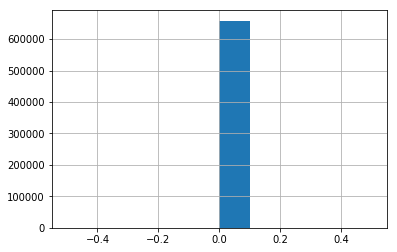

In [292]:
df_no_mixed.isnull().sum(axis=1).sort_values(ascending=False).hist()

In [293]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [316]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame df; Feature Dataframe feat_info
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # convert feat_info 'missing_or_unknown' to lists so I can work with the values
    if type(feat_info['missing_or_unknown'].values[0]) == str:
        feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    
    # convert to dict for speed and convenience
    feat_dict = feat_info.set_index('attribute').to_dict(orient='dict')
    
    # function to map missing or unknown values to NaN
    def nan_fill(x, col):
        if str(x) in feat_dict['missing_or_unknown'][col]:
            return np.nan
        return x

    # process missing values in df (convert to NaNs)
    x = 1
    for col in df.columns:
        df[col] = df[col].apply(lambda x: nan_fill(x, col))
        print('processed ' + str(x) + ' of ' + str(len(df.columns)))
        x+=1
    
    # remove selected columns and rows, ...
    # COLUMNS
    # assuming we want to remove the 3 columns with the most missing data
    nan_outliers = df.isnull().sum().sort_values(ascending=False)[:3].index.tolist()
    df = df.drop(columns = nan_outliers)
    
    # ROWS
    # assuming we want to remove rows missing 1 or more features
    df['missing_r'] = df.isnull().sum(axis=1)
    df = df[df['missing_r'] < 1]
    
    # select, re-encode, and engineer column values.
    ################################### CATEGORICAL ###########################################
    hit_or_miss = feat_info[feat_info['attribute'].isin(df.isnull().sum().sort_values(ascending=False).index.tolist())]
    if 'missing' not in hit_or_miss.columns:
        hit_or_miss = hit_or_miss.merge(df.isnull().sum().rename('missing'), how='left', left_on='attribute', right_index=True)
    hit_or_miss.sort_values(by = 'missing', ascending = False, inplace=True)
    
    df_cat = hit_or_miss[hit_or_miss['type'] == 'categorical']

    def valfinder(col):
        if col in df.columns:
            return list(df[col].value_counts().index.values)
        return np.nan

    df_cat['vals'] = df_cat['attribute'].apply(lambda x: valfinder(x))

    def encode_decision(x):
        if type(x) == list:
            if len(x) <= 2:
                return 'no change'
            return 'one hot encode'
        return 'na'

    df_cat['encode_method'] = df_cat['vals'].apply(lambda x: encode_decision(x))
    x = df_cat[df_cat['attribute'] == 'OST_WEST_KZ'].index.values[0]
    df_cat.set_value(x, 'encode_method', 'one hot encode')
    
    # one hot encode categorical variables where applicable
    df_encoded = df.copy()

    encode_dict = df_cat.set_index('attribute').to_dict(orient='dict')

    # perform one hot encoding
    drop_encode_cols = []
    for col in df.columns:
        if col in encode_dict['encode_method'].keys():
            if 'one hot encode' in encode_dict['encode_method'][col]:
                drop_encode_cols.append(col)
                df_encoded = df_encoded.join(pd.get_dummies(df_encoded[col], prefix=col))
                
    df_encoded = df_encoded.drop(columns = drop_encode_cols)
    print('Dropped the following one-hot-encoded categorical columns:')
    print(drop_encode_cols)
    
    ################################### MIXED ###########################################
    # decade map
    interval_dict = {1:40, 2:40,
                    3:50, 4:50,
                    5:60, 6:60, 7:60,
                    8:70, 9:70,
                    10:80, 11:80, 12:80, 13:80,
                    14:90, 15:90}
    df_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(interval_dict)
    
    # movement map
    movement_dict = {1:'mainstream',
                    2:'avantgarde',
                    3:'mainstream',
                    4:'avantgarde',
                    5:'mainstream',
                    6:'avantgarde',
                    7:'avantgarde',
                    8:'mainstream',
                    9:'avantgarde',
                    9:'avantgarde',
                    10:'mainstream',
                    11:'avantgarde',
                    12:'mainstream',
                    13:'avantgarde',
                    14:'mainstream',
                    15:'avantgarde'}
    df_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df_encoded['PRAEGENDE_JUGENDJAHRE_mainstream'] = df_encoded['PRAEGENDE_JUGENDJAHRE_movement'].map({'mainstream':1, 'avantgarde':0})
    
    # wealth encoding
    df_encoded['CAMEO_INTL_2015_wealth'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)//10
    
    # life stage encoding
    df_encoded['CAMEO_INTL_2015_lifestage'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)%10

    # drop mixed one-hot-encoded
    df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)
    df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE_movement'], inplace = True)
    df_encoded.drop(columns = ['CAMEO_INTL_2015'], inplace = True)
    
    # drop extra mixed
    df_no_mixed = df_encoded.drop(columns = ['KBA05_BAUMAX',
                                         'PLZ8_BAUMAX',
                                         'WOHNLAGE',
                                         'LP_LEBENSPHASE_GROB',
                                         'LP_LEBENSPHASE_FEIN'])
    
    # Return the cleaned dataframe.
    return df_no_mixed
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [295]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [296]:
features_final = hit_or_miss[hit_or_miss['attribute'].isin(df_no_mixed.columns)]
features_final['type'].value_counts()

ordinal        49
numeric         6
categorical     4
interval        1
Name: type, dtype: int64

In [129]:
features_final[features_final.type == 'numeric']

,attribute,information_level,type,missing_or_unknown,missing
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[],105800
51,ANZ_HH_TITEL,building,numeric,[],97008
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0],93148
54,MIN_GEBAEUDEJAHR,building,numeric,[0],93148
45,ANZ_TITEL,household,numeric,[],73499
44,ANZ_PERSONEN,household,numeric,[],73499


In [297]:
# Apply feature scaling to the general population demographics data.

# I am trying applying it to all columns regardless of dtype
scaler = StandardScaler()
df_scaled = df_no_mixed.copy()
df_scaled[df_scaled.columns]= scaler.fit_transform(df_scaled[df_scaled.columns])
df_scaled.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_mainstream,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,-1.738497,0.976850,-1.515654,1.578780,-1.041082,1.512628,1.041577,1.351269,-0.547400,1.032879,...,-0.154234,-0.164183,-0.192302,-0.180597,-0.193145,-0.075468,1.159523,0.547400,1.175568,-1.260963
2,0.205704,0.976850,-1.515654,0.898182,-1.762085,-0.552046,0.313883,1.351269,1.826817,1.032879,...,-0.154234,-0.164183,-0.192302,-0.180597,-0.193145,-0.075468,1.159523,-1.826817,-0.869321,0.748876
4,0.205704,-1.023699,0.680911,0.217585,0.400926,-1.240270,0.313883,-0.836438,-0.547400,1.032879,...,-0.154234,-0.164183,-0.192302,-0.180597,-0.193145,-0.075468,-0.220405,0.547400,0.493939,0.078930
5,-1.738497,0.976850,-0.051277,-1.143610,1.121929,-0.552046,-0.413811,1.351269,-0.547400,1.032879,...,-0.154234,-0.164183,-0.192302,-0.180597,-0.193145,-0.075468,-1.600334,0.547400,1.175568,0.748876
6,-0.766397,0.976850,-1.515654,1.578780,-1.762085,1.512628,1.041577,-0.107202,-0.547400,-0.288954,...,-0.154234,-0.164183,-0.192302,-0.180597,-0.193145,-0.075468,0.469559,0.547400,-0.869321,-0.591017


### Discussion 2.1: Apply Feature Scaling

Reporting your decisions regarding feature scaling.

<font color=blue>I have applied a StandardScaler to scale all columns of the data, regardless of datatype.<font>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [298]:
# Helper function
def pca_results(full_dataset, pca):
    '''
    Create a dataframe of the PCA results, visualize explained variance
    '''
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14, 8))
    
    # Plot feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel('Feature Weights')
    ax.set_xticklabels(dimensions, rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, 'Explained Variance\n%,4f'%(ev))
        
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [299]:
comp_min = 60

ev_list = [0]*comp_min

In [300]:
# Apply PCA to the data.

comp_min = 1

ev_list = [0] * comp_min

for comp in range(comp_min, df_scaled.shape[1]):
    pca = PCA(comp)
    X_pca = pca.fit_transform(df_scaled)
    ev = pca.explained_variance_ratio_.sum()
    ev_list.append(ev)
    print(str(comp) + ', ' + str(ev))
    if ev > 0.85:
        break

1, 0.07829526075149604
2, 0.1352338217765215
3, 0.16991407679314877
4, 0.19639625277724404
5, 0.21688520973283396
6, 0.233882942493357
7, 0.24918740936613964
8, 0.26391747911473257
9, 0.2774875284492234
10, 0.29009605289537366
11, 0.3023218611907137
12, 0.31394232657719323
13, 0.3253369741951877
14, 0.3364889618745219
15, 0.3477752391378759
16, 0.35870736759895744
17, 0.3695646987099632
18, 0.38016835688894557
19, 0.39057010428937183
20, 0.40076562657997833
21, 0.4090862013590127
22, 0.4185276487213345
23, 0.4282805412760426
24, 0.43727475583724607
25, 0.44563981879102244
26, 0.4539904578722017
27, 0.4625787413499159
28, 0.4688276003847977
29, 0.47664177788104906
30, 0.48432417004663125
31, 0.4908501284824381
32, 0.49685185786828134
33, 0.503847227263748
34, 0.5090227854319268
35, 0.5163030041032057
36, 0.5211819759173916
37, 0.5273795043147819
38, 0.5338164497276539
39, 0.5390753503056736
40, 0.5454204454536657
41, 0.5504781502666903
42, 0.5565048101197713
43, 0.5613587320822403
44, 0

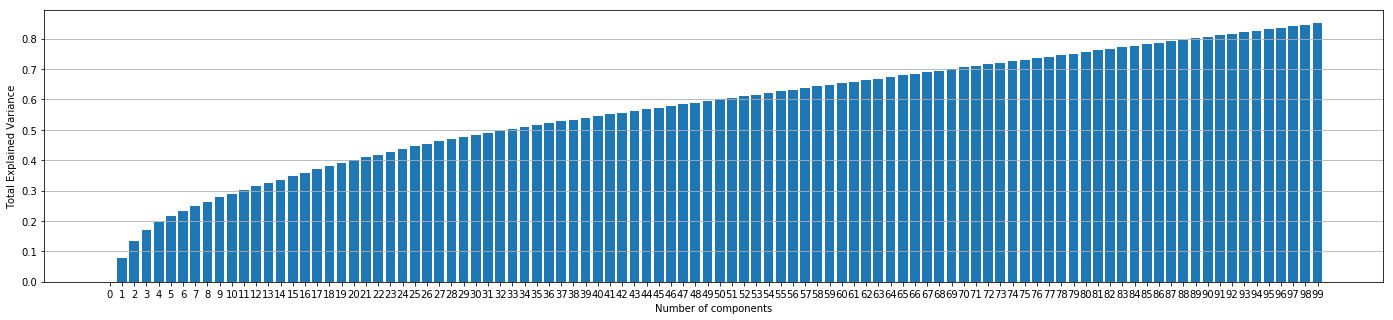

In [301]:
x = ev_list
rx = list(range(len(x)))
# plot
fig = plt.figure(figsize = (24, 5))
plt.bar(rx, x)
plt.xticks(np.arange(min(rx), max(rx)+1, 1.0));
plt.grid(axis = 'y')
plt.ylabel('Total Explained Variance');
plt.xlabel('Number of components');

#num_comps = comp_check.shape[0]
#print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()))

In [302]:
plt.savefig('PCA_comp_var.png')

<Figure size 432x288 with 0 Axes>

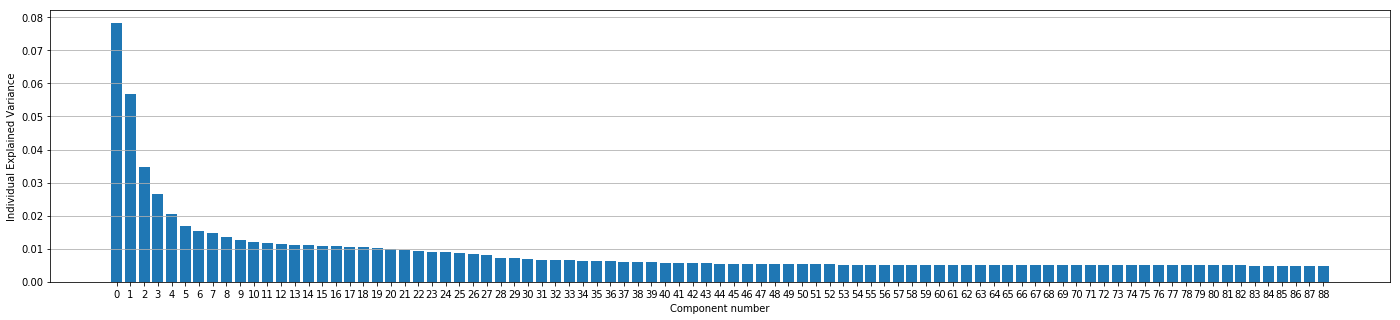

In [303]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Aiming for 80% explained variance

pca = PCA(89)
X_pca = pca.fit_transform(df_scaled)
ev = pca.explained_variance_ratio_

pca_df = pd.DataFrame(X_pca)

rx = list(range(len(ev)))
# plot
fig = plt.figure(figsize = (24, 5))
plt.bar(rx, ev)
plt.xticks(np.arange(min(rx), max(rx)+1, 1.0));
plt.grid(axis = 'y')
plt.ylabel('Individual Explained Variance');
plt.xlabel('Component number');


In [304]:
# save transformed dataframe, original dataframe, and model - this takes a while
pca_df.to_csv('pca_df.csv', index=False)
print('pca_df saved')
joblib.dump(pca, 'pca.joblib')
df_scaled.to_csv('df_scaled.csv', index = False)
print('df_scaled saved')

pca_df saved
df_scaled saved


In [165]:
# load transformed pca dataframe, pca model, and original dataframe
pca_df = pd.read_csv('pca_df.csv')
print('pca_df loaded')
pca = joblib.load('pca.joblib')
df_scaled = pd.read_csv('df_scaled.csv')
print('df_scaled loaded')

pca_df loaded
df_scaled loaded


### Discussion 2.2: Perform Dimensionality Reduction

Report your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?

<font color=blue>I found that there were seriously diminishing returns on how much variance I could account for with PCA - 1 component could explain about 8% of the variance, but each component after 22 was only explaining 0.1% of the variance, and by 80 components the marginal gain was about 0.05% of the total dataset variance. I decided to settle on a 89 components, because at that reduction I was still accounting for 80% of the dataset's variance while reducing the number of features by over 120. So my new transformed dataset has 89 features.<font>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

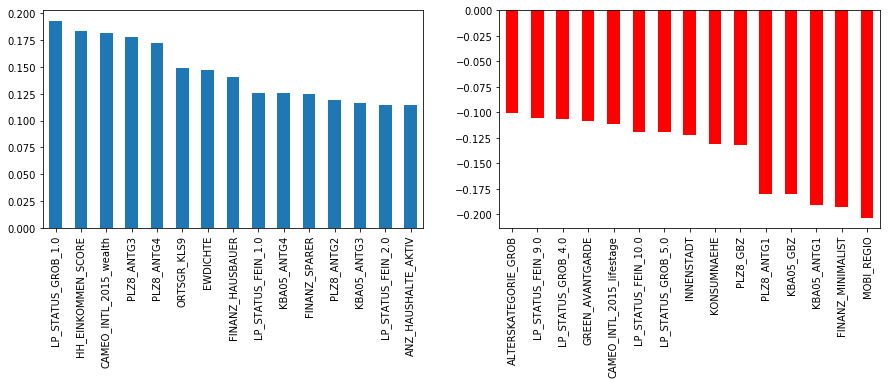

In [305]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def comp_weights(pca, dimension, num_features, df):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = [i for i in range(1, len(pca.components_)+1)]

    weights = components.iloc[dimension-1]
    fig, ax = plt.subplots(figsize = (15, 4), ncols=2, nrows = 1)
    weights.sort_values(ascending=False)[:num_features].plot(kind='bar', ax = ax[0]);
    weights.sort_values(ascending=False)[-num_features:].plot(kind='bar', ax = ax[1], color = 'red');
    
comp_weights(pca, 1, 15, df_scaled)

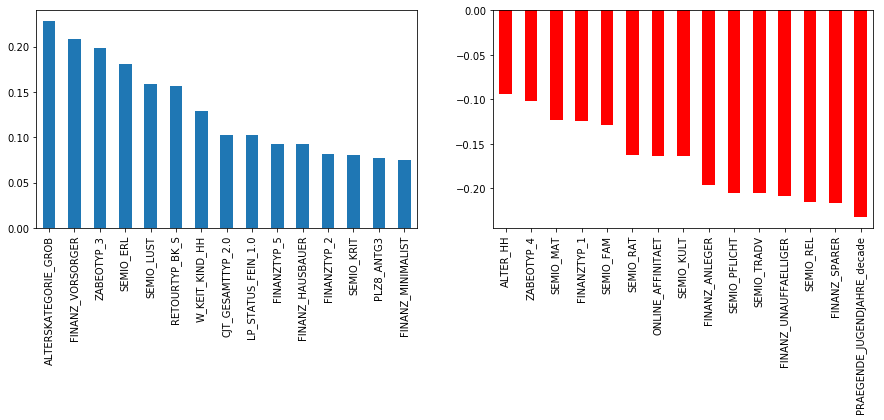

In [306]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_weights(pca, 2, 15, df_scaled)

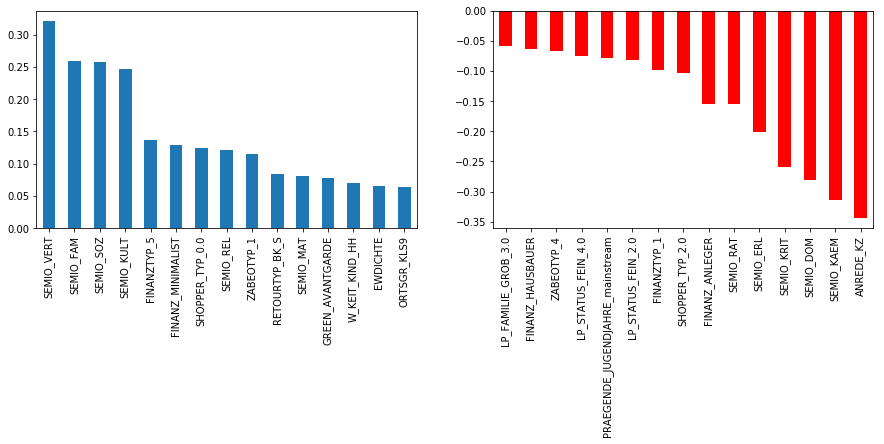

In [307]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_weights(pca, 3, 15, df_scaled)

### Discussion 2.3: Interpret Principal Components

Report your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?

Dimension 1:
 - (+) social status, rough scale (income) [^ high earners]
 - (+) Estimated household net income [^ low earners]
 - (+) Custom wealth score mapping [^ low earners]
 - (-) Movement patterns [^ no movement]
 - (-) Financial typology, for each dimension (low financial interest) [^ low typology]
 - (-) Number of 1-2 family houses in the microcell [^ many 1-2 family homes]
 
Dimension 2:
 - (+) Estimate age based on name [^ elderly/uniform distribution]
 - (+) Financial typology, for each dimension (be prepared) [^ low typology]
 - (+) Energy consumption typology [^ indifferent/unknown]
 - (-) Decade of youth [^ more recent]
 - (-) Financial typology, for each dimension (money saver) [^ low typology]
 - (-) Personality typology, for each dimension (religious) [^ high affinity/unknown]
 
Dimension 3:
 - (+) Personality typology, for each dimension (dreamful) [^ high affinity/unknown]
 - (+) Personality typology, for each dimension (family minded) [^ high affinity/unknown]
 - (+) Personality typology, for each dimension (socially minded) [^ high affinity/unknown]
 - (-) gender [^ female]
 - (-) Personality typology, for each dimension (combative attitude) [^ high affinity/unknown]
 - (-) Personality typology, for each dimension (dominant minded) [^ high affinity/unknown]
 
----------------

<font color=blue>Dimension 1 appears to pertain to economic status, although the relation between the top feature (LP_STATUS_GROB) is the opposite from what I would expect, with top earners in that category correlating positively with bottom earners in the next two features. The top earners in the LP_STATUS_GROB feature also correlate negatively with movement, meaning they move frequently, correlate negatively with low financial interest, meaning they are very interested in finance, and correlate negatively with 1-2 family houses in the microcell, meaning that there are very few 1-2 family houses in their locale.

<font color=blue>Dimension 2 appears to pertain to age, with elderly, energy indifferent, and prepared-minded features correlating positively with one another and negatively with decade of youth, indifference to money saving, and religiousity. The religious aspect surprised me - I would have expected older populations to be more religious, not less.

<font color=blue>Dimension 3 appears to correlate with personality, with positive correlations between dreamful, family-minded, and socially minded attributes, and negative correlations between combative-attitude and dominant-mindedness. Also it should be noted that there was a negative correlation with the female gender here.<font>


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [308]:
# Over a number of different cluster counts...
def get_kmeans_scores(data, k):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data: the dataset to which you want to fit the kmeans
        k: the number of clusters you would like
        
    OUTPUT:
        score: the SSE score for the kmeans model fit to the data
    '''

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = k)
    model = kmeans.fit(data)

    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    return score    
    

completed run with k = 1
completed run with k = 2
completed run with k = 3
completed run with k = 4
completed run with k = 5
completed run with k = 6
completed run with k = 7
completed run with k = 8
completed run with k = 9
completed run with k = 10
completed run with k = 11
completed run with k = 12
completed run with k = 13
completed run with k = 14
completed run with k = 15
completed run with k = 16
completed run with k = 17
completed run with k = 18
completed run with k = 19
completed run with k = 20
completed run with k = 21
completed run with k = 22
completed run with k = 23
completed run with k = 24
completed run with k = 25
completed run with k = 26
completed run with k = 27
completed run with k = 28
completed run with k = 29
completed run with k = 30
completed run with k = 31
completed run with k = 32
completed run with k = 33
completed run with k = 34
completed run with k = 35
completed run with k = 36
completed run with k = 37
completed run with k = 38
completed run with k 

Text(0, 0.5, 'SSE')

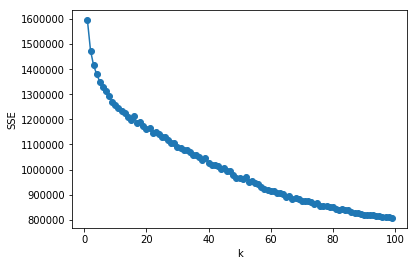

In [309]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Scree plot
scores = []
k_s = list(range(1, 100))

for k in k_s:
    scores.append(get_kmeans_scores(pca_df.sample(n=10000, random_state=1), k))
    print('completed run with k = ' + str(k))
    
plt.plot(k_s, scores, marker = 'o')
plt.xlabel('k')
plt.ylabel('SSE')


In [310]:
plt.savefig('k_means_custers.png')

<Figure size 432x288 with 0 Axes>

Run with k = 4: 80.44996500015259
Run with k = 5: 73.3989098072052
Run with k = 6: 89.17187738418579
Run with k = 7: 98.05546975135803
Run with k = 8: 118.84409499168396
Run with k = 9: 169.79773545265198
Run with k = 10: 175.16312742233276
Run with k = 11: 182.81566524505615
Run with k = 12: 217.3353235721588
Run with k = 13: 280.6890666484833
Run with k = 14: 262.9913456439972
Run with k = 15: 274.30585741996765


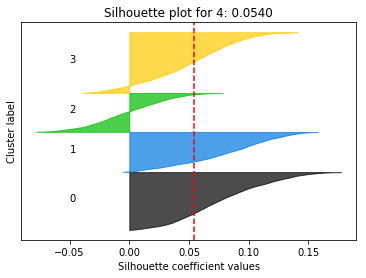

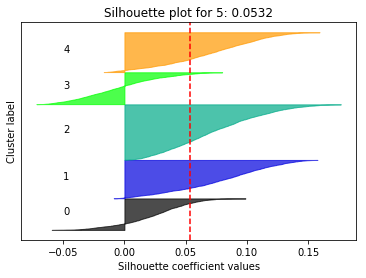

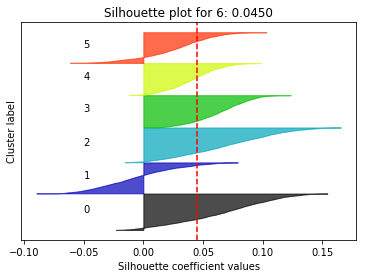

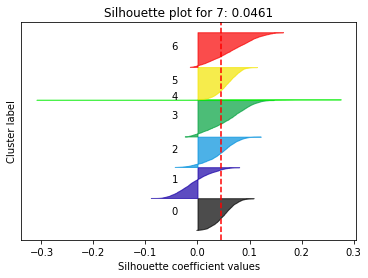

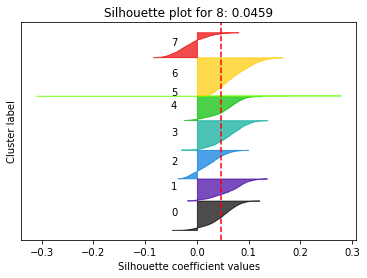

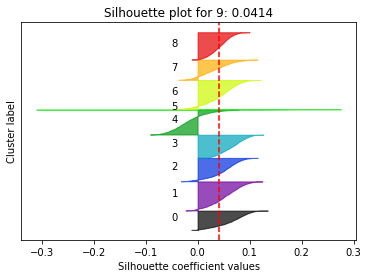

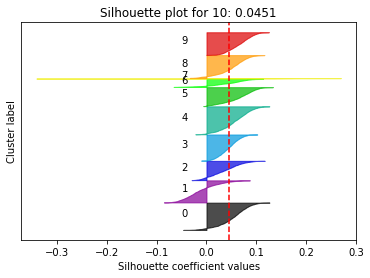

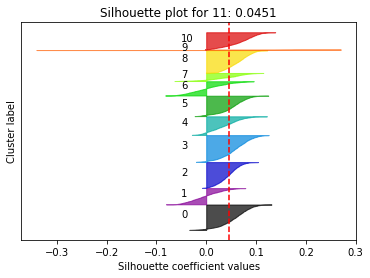

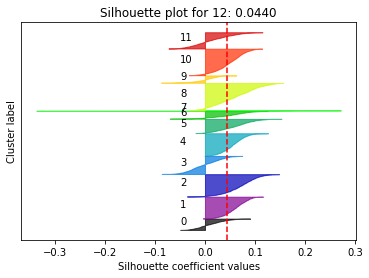

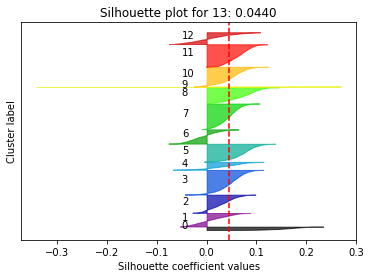

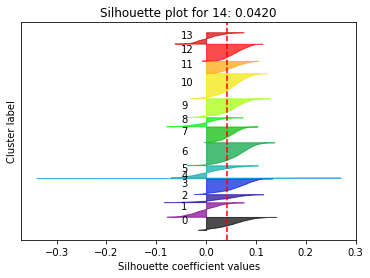

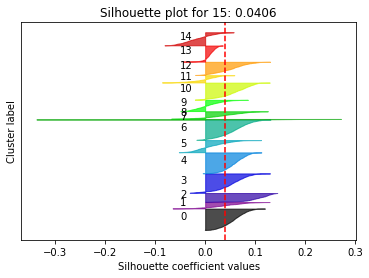

In [311]:
# Investigate with Silhouette score
# The silhouette coefficient can range from -1, 1

range_n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    start = time.time()

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pca_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    test_df = pca_df.copy()
    test_df['cluster_labels'] = cluster_labels
    test_df_sample = test_df.sample(n=10000, random_state=1)

    silhouette_avg = silhouette_score(test_df_sample.drop(columns = ['cluster_labels']), test_df_sample['cluster_labels'])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(test_df_sample.drop(columns = ['cluster_labels']), test_df_sample['cluster_labels'])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[test_df_sample['cluster_labels'].values == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title('Silhouette plot for ' + str(n_clusters) + ': ' + str("%.4f" % silhouette_avg))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    end = time.time()
    print('Run with k = ' + str(n_clusters) + ': ' + str(end - start))

plt.show()

In [349]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# it appears that I want 10 clusters
kmeans = KMeans(n_clusters = 10)
model = kmeans.fit(pca_df)
# make a new dataframe which is a copy of the pca frame, and add a labels column for the kmeans labels
gen_pop_labels = pca_df.copy()
gen_pop_labels['labels'] = model.predict(pca_df)

### Discussion 3.1: Apply Clustering to General Population

Report your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?

<font color=blue>It is very difficult to determine an appropriate number of clusters based on the scree plot alone, as there is not a well defined elbow. From the scree plot, it appears that the marginal benefit of an additional cluster beyond 10 clusters levels out, but only slightly - so it is possible that it would be appropriate to use anywhere from 10 to 30 clusters. I used a few silhouette plots to examine the clusters further, and observed how well individual points fit each cluster. Each point is scored on a scale of -1 to 1, with 1 being a perfect match and -1 being a poor match. None of the cluster sizes performed particularly well, but I have chosen to proceed with 10 clusters. to continue the project.<font>

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [313]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [317]:
# Apply preprocessing, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_customers = clean_data(customers, feat_info)
clean_customers.head()


processed 1 of 85
processed 2 of 85
processed 3 of 85
processed 4 of 85
processed 5 of 85
processed 6 of 85
processed 7 of 85
processed 8 of 85
processed 9 of 85
processed 10 of 85
processed 11 of 85
processed 12 of 85
processed 13 of 85
processed 14 of 85
processed 15 of 85
processed 16 of 85
processed 17 of 85
processed 18 of 85
processed 19 of 85
processed 20 of 85
processed 21 of 85
processed 22 of 85
processed 23 of 85
processed 24 of 85
processed 25 of 85
processed 26 of 85
processed 27 of 85
processed 28 of 85
processed 29 of 85
processed 30 of 85
processed 31 of 85
processed 32 of 85
processed 33 of 85
processed 34 of 85
processed 35 of 85
processed 36 of 85
processed 37 of 85
processed 38 of 85
processed 39 of 85
processed 40 of 85
processed 41 of 85
processed 42 of 85
processed 43 of 85
processed 44 of 85
processed 45 of 85
processed 46 of 85
processed 47 of 85
processed 48 of 85
processed 49 of 85
processed 50 of 85
processed 51 of 85
processed 52 of 85
processed 53 of 85
pr

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Dropped the following one-hot-encoded categorical columns:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_mainstream,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,50,0,1,3
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,50,0,3,4
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,70,1,4,1
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,50,0,3,4
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,50,0,2,3


In [326]:
# apply feature scaling
customers_scaled = clean_customers.copy()
customers_scaled[customers_scaled.columns] = scaler.fit_transform(customers_scaled[customers_scaled.columns])
customers_scaled.head()

# This step added to add one-hot-encodings which may not have existed in the new dataset
missing_encodings = list(set(df_no_mixed.columns) - set(customers_scaled.columns))
for col in missing_encodings:
    customers_scaled[col] = 0
    print('added: ' + str(col))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


added: GEBAEUDETYP_5.0
added: TITEL_KZ_2.0


In [327]:
list(set(df_no_mixed.columns) - set(customers_scaled.columns))

[]

In [355]:
# Apply PCA and clustering from the original general demographics data
customers_pca = pd.DataFrame(pca.transform(customers_scaled))
customers_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,-2.654646,1.155129,2.863360,-0.194529,-0.319203,-0.606064,0.127190,-2.414265,0.565625,-0.118156,...,-0.079039,-0.150747,-0.729507,0.007414,1.512176,-0.420603,0.557711,-0.378575,0.067580,-0.931706
1,0.548764,3.453842,-2.798852,1.123648,-2.565546,-1.051604,1.343346,0.762967,0.250448,0.241369,...,0.122758,0.343753,0.340357,1.068111,0.059483,0.916242,1.317399,0.180734,-0.105952,-0.670339
2,4.164422,-2.986179,-0.092789,0.974343,2.106406,-0.425866,-1.623440,0.293092,0.287012,0.522314,...,-0.557184,0.766353,1.330461,0.202407,-0.684309,-0.858059,-0.591024,0.815197,1.634891,0.020550
3,-0.026953,-0.589764,2.524775,0.746971,-0.859833,1.558292,-1.219523,-0.516939,0.406773,1.693710,...,-0.791886,0.996822,-0.103236,1.243983,-0.392588,0.508549,0.338711,-1.040840,0.585520,-1.025407
4,-3.782742,-0.228929,1.824569,0.537776,-1.762493,-1.035396,0.096378,-0.728523,0.782346,-1.344323,...,0.489570,-0.195309,1.841865,0.327836,2.278755,0.396599,-0.535857,-0.565187,-1.004311,-0.362877


In [370]:
# Apply clustering from the general demographics onto the customer data,
# obtaining cluster predictions for the customer demographics data
customers_labels = customers_pca.copy()
customers_labels['labels'] = model.predict(customers_pca)

# create series for distributions of customers and general population
cust_label_series = (customers_labels['labels'].value_counts()/len(customers_labels)).rename('customers')
gen_label_series = (gen_pop_labels['labels'].value_counts()/len(gen_pop_labels)).rename('general pop')

# join into one dataframe
labels_df = pd.concat([cust_label_series, gen_label_series], axis = 1)
labels_df

,customers,general pop
0,0.000496,0.002545
1,0.010259,0.034171
2,0.052743,0.149411
3,0.179533,0.131578
4,0.098649,0.085492
5,0.144696,0.145043
6,0.190743,0.148846
7,0.075783,0.100356
8,0.065251,0.042541
9,0.181847,0.160017


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 0, 'Group label')

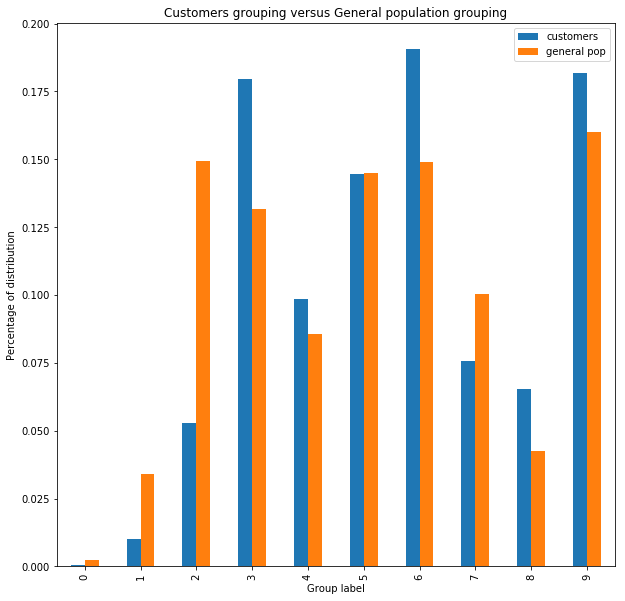

In [376]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

labels_df.plot(kind = 'bar', figsize = (10,10))
plt.title('Customers grouping versus General population grouping')
plt.ylabel('Percentage of distribution')
plt.xlabel('Group label')

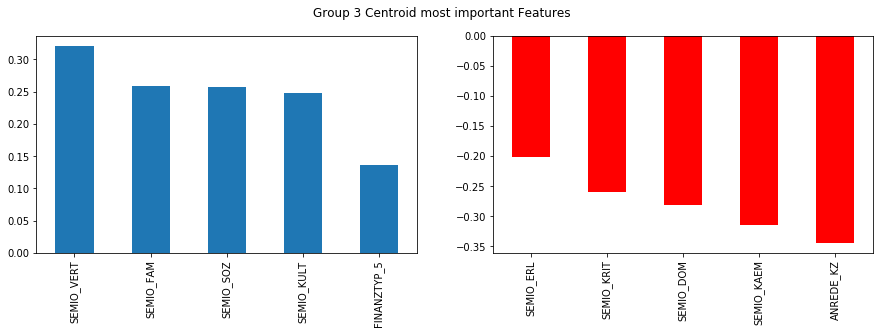

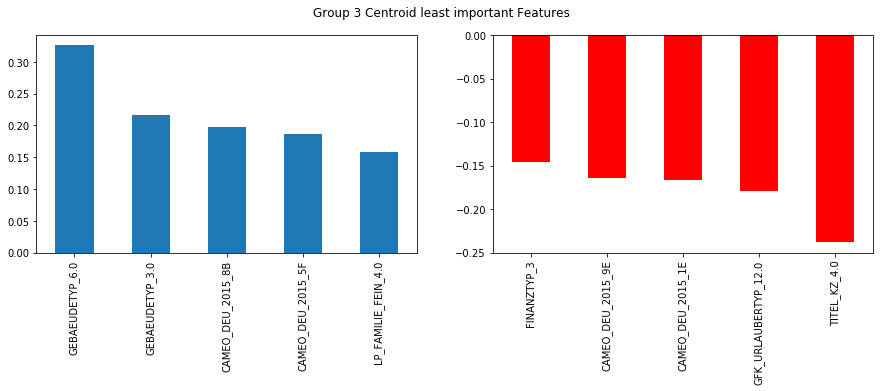

In [398]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Groups 3 and 6 are most overrepresented by the customer dataset

# This line gets the index of the most important PCA feature for group 3
pca_feat_max = pd.Series(model.cluster_centers_[3]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(model.cluster_centers_[3]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
comp_weights(pca, pca_feat_max, 5, customers_scaled)
plt.suptitle('Group 3 Centroid most important Features');

comp_weights(pca, pca_feat_min, 5, customers_scaled)
plt.suptitle('Group 3 Centroid least important Features');

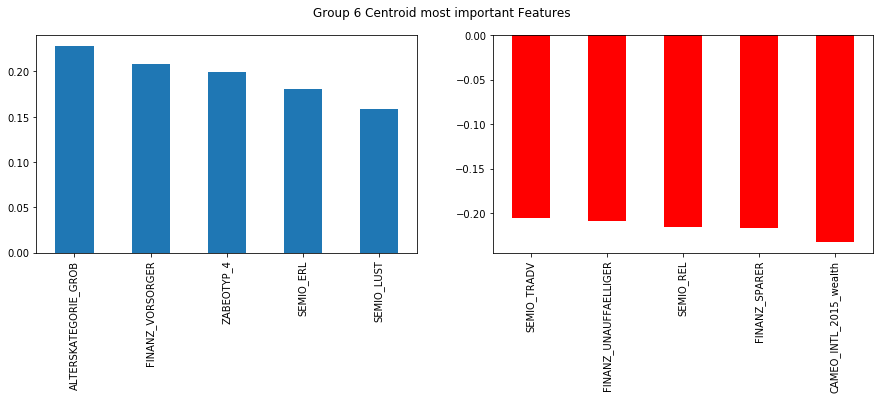

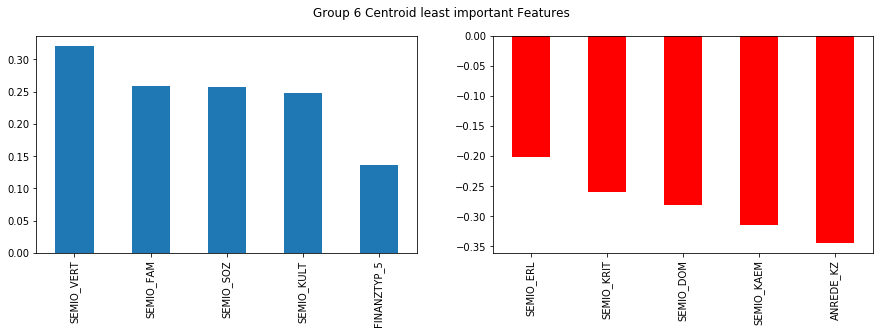

In [400]:
# Same plots for group 6
# This line gets the index of the most important PCA feature for group 6
pca_feat_max = pd.Series(model.cluster_centers_[6]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(model.cluster_centers_[6]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
comp_weights(pca, pca_feat_max, 5, customers_scaled)
plt.suptitle('Group 6 Centroid most important Features');

comp_weights(pca, pca_feat_min, 5, customers_scaled)
plt.suptitle('Group 6 Centroid least important Features');

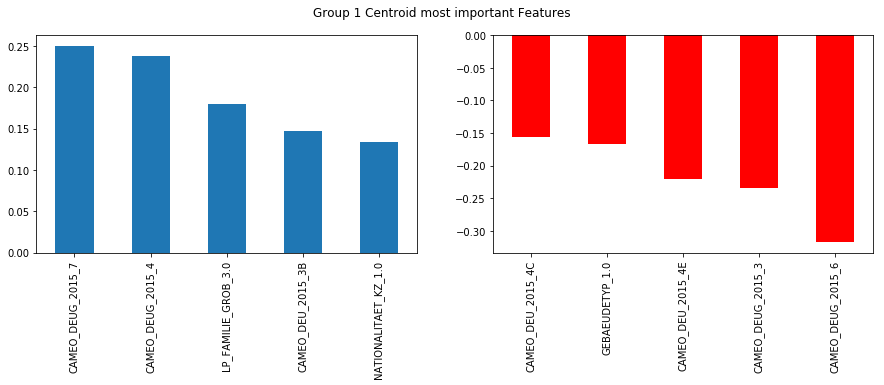

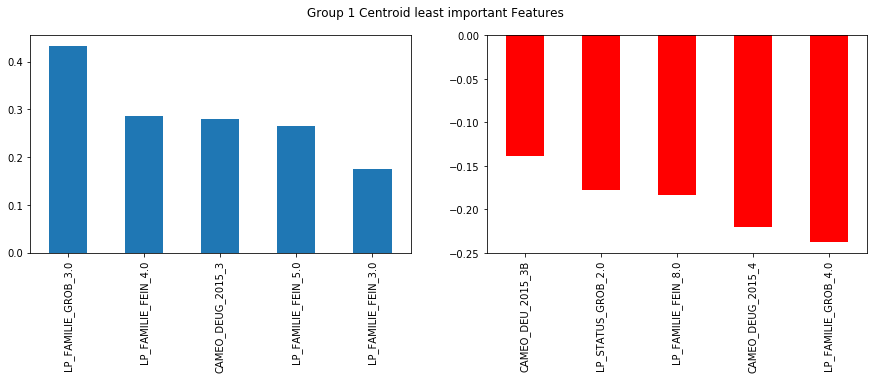

In [401]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Groups 1 and 2 are overrepresented by the general population
# Same plots for group 1
# This line gets the index of the most important PCA feature for group 1
pca_feat_max = pd.Series(model.cluster_centers_[1]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(model.cluster_centers_[1]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
comp_weights(pca, pca_feat_max, 5, customers_scaled)
plt.suptitle('Group 1 Centroid most important Features');

comp_weights(pca, pca_feat_min, 5, customers_scaled)
plt.suptitle('Group 1 Centroid least important Features');

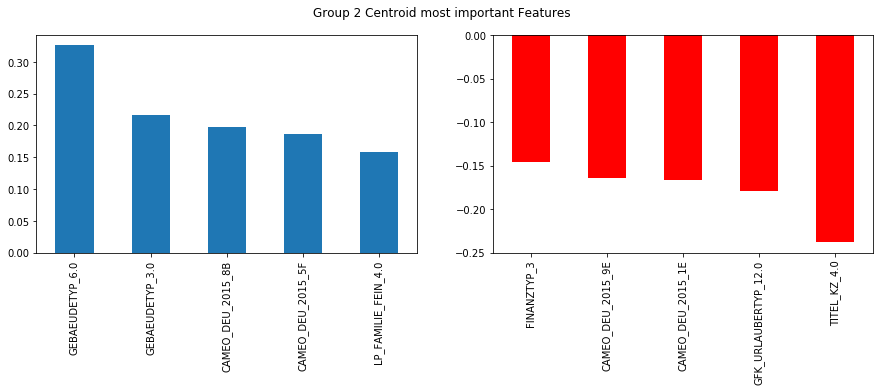

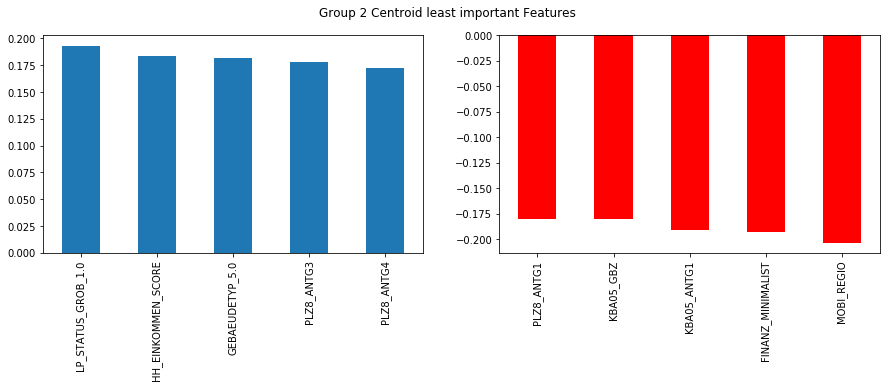

In [402]:
# Same plots for group 2
# This line gets the index of the most important PCA feature for group 2
pca_feat_max = pd.Series(model.cluster_centers_[2]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(model.cluster_centers_[2]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
comp_weights(pca, pca_feat_max, 5, customers_scaled)
plt.suptitle('Group 2 Centroid most important Features');

comp_weights(pca, pca_feat_min, 5, customers_scaled)
plt.suptitle('Group 2 Centroid least important Features');

In [405]:
# Analysis of data with missing values
# df_above_thresh has 73k rows, just under 10% of the original dataset
df_above_thresh.shape

(73607, 83)

In [ ]:
def clean_post_missing(df, feat_info)
# perform cleaning on it, minus column and row cleaning
# select, re-encode, and engineer column values.
    hit_or_miss = feat_info[feat_info['attribute'].isin(df.isnull().sum().sort_values(ascending=False).index.tolist())]
    if 'missing' not in hit_or_miss.columns:
        hit_or_miss = hit_or_miss.merge(df.isnull().sum().rename('missing'), how='left', left_on='attribute', right_index=True)
    hit_or_miss.sort_values(by = 'missing', ascending = False, inplace=True)
    
    df_cat = hit_or_miss[hit_or_miss['type'] == 'categorical']

    def valfinder(col):
        if col in df.columns:
            return list(df[col].value_counts().index.values)
        return np.nan

    df_cat['vals'] = df_cat['attribute'].apply(lambda x: valfinder(x))

    def encode_decision(x):
        if type(x) == list:
            if len(x) <= 2:
                return 'no change'
            return 'one hot encode'
        return 'na'

    df_cat['encode_method'] = df_cat['vals'].apply(lambda x: encode_decision(x))
    x = df_cat[df_cat['attribute'] == 'OST_WEST_KZ'].index.values[0]
    df_cat.set_value(x, 'encode_method', 'one hot encode')
    
    # one hot encode categorical variables where applicable
    df_encoded = df.copy()

    encode_dict = df_cat.set_index('attribute').to_dict(orient='dict')

    # perform encoding
    for col in df.columns:
        if col in encode_dict['encode_method'].keys():
            if 'one hot encode' in encode_dict['encode_method'][col]:
                df_encoded = df_encoded.join(pd.get_dummies(df_encoded[col], prefix=col))
    
    # decade map
    interval_dict = {1:40, 2:40,
                    3:50, 4:50,
                    5:60, 6:60, 7:60,
                    8:70, 9:70,
                    10:80, 11:80, 12:80, 13:80,
                    14:90, 15:90}
    df_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(interval_dict)
    
    # movement map
    movement_dict = {1:'mainstream',
                    2:'avantgarde',
                    3:'mainstream',
                    4:'avantgarde',
                    5:'mainstream',
                    6:'avantgarde',
                    7:'avantgarde',
                    8:'mainstream',
                    9:'avantgarde',
                    9:'avantgarde',
                    10:'mainstream',
                    11:'avantgarde',
                    12:'mainstream',
                    13:'avantgarde',
                    14:'mainstream',
                    15:'avantgarde'}
    df_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df_encoded['PRAEGENDE_JUGENDJAHRE_mainstream'] = df_encoded['PRAEGENDE_JUGENDJAHRE_movement'].map({'mainstream':1, 'avantgarde':0})
    
    # wealth encoding
    df_encoded['CAMEO_INTL_2015_wealth'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)//10
    
    # life stage encoding
    df_encoded['CAMEO_INTL_2015_lifestage'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)%10

    # drop
    df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)
    df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE_movement'], inplace = True)
    df_encoded.drop(columns = ['CAMEO_INTL_2015'], inplace = True)
    
    df_no_mixed = df_encoded.drop(columns = ['KBA05_BAUMAX',
                                         'PLZ8_BAUMAX',
                                         'WOHNLAGE',
                                         'LP_LEBENSPHASE_GROB',
                                         'LP_LEBENSPHASE_FEIN'])
    
    # Return the cleaned dataframe.
    return df_no_mixed

### Discussion 3.3: Compare Customer Data to Demographics Data

Report findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

-------------------------

### Popular with company
Group 5 was overrepresented by the customer base. I have analyzed this group to see which PCA components had the most positive and negative impacts on the cluster, and then analyzed those PCA components to see which features had the most impact on the feature. I have included details on both the most positive-positive features, and negative-negative features; the logic there being that if a component was strongly negatively weighted in a cluster, then the most negatively weighted features of that PCA component would have a positive influence on the cluster. Negative-negative features are marked below with '# INVERSE'. Group 5 appears to be comprised of elderly, financially unprepared, either single or family types. This makes sense if the company is offering some kind of late-stage financial service which would interest these types of people moreso than single young people.

#### GROUP 5
- ALTERSKATEGORIE_GROB # age based on name analysis [^elderly]
- FINANZ_VORSORGER # financial typology: be prepared [^low propensity]
- ZABEOTYP_6 # energy consumption indifferent
- LP_FAMILIE_FEIN_2.0 # INVERSE # family type: couple
- LP_FAMILIE_GROB_3.0 # INVERSE # family type: single parent

---------------------------------------

### Unpopular with company
Group 5 was overrepresented in the general population compared to the company customer base. I have performed the same analysis as above on this group. Group 5 appears to be practically minded, non social or family oriented individuals
appears to be families in the lower to mid class who are supporting a family and maybe not concerned with saving. Group 2 appears to be families living in mixed inhabitant buildings, indicating that perhaps they live in urban areas and are less likely to own. These results make sense because they contrast the thoughtful, educated, finance oriented groups which are popular with the company. If the company is offering some kind of financial service, then these groups are what I would expect.

#### GROUP 1
- SEMIO_VERT # personality typology: dreamful [^low affinity]
- SEMIO_FAM # personality typology: family-minded [^low affinity]
- SEMIO_SOZ # personality typology: socially-minded [^low affinity]
- CAMEO_DEU_2015_4B # Wealth / Life Stage typology: Family Life
- CAMEO_DEU_2015_2B # Wealth / Life Stage typology: Noble Jogger

--------------------

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
def clean_post_missing(df, feat_info):
# perform cleaning on it, minus column and row cleaning
# select, re-encode, and engineer column values.
    hit_or_miss = feat_info[feat_info['attribute'].isin(df.isnull().sum().sort_values(ascending=False).index.tolist())]
    if 'missing' not in hit_or_miss.columns:
        hit_or_miss = hit_or_miss.merge(df.isnull().sum().rename('missing'), how='left', left_on='attribute', right_index=True)
    hit_or_miss.sort_values(by = 'missing', ascending = False, inplace=True)
    
    df_cat = hit_or_miss[hit_or_miss['type'] == 'categorical']

    def valfinder(col):
        if col in df.columns:
            return list(df[col].value_counts().index.values)
        return np.nan

    df_cat['vals'] = df_cat['attribute'].apply(lambda x: valfinder(x))

    def encode_decision(x):
        if type(x) == list:
            if len(x) <= 2:
                return 'no change'
            return 'one hot encode'
        return 'na'

    df_cat['encode_method'] = df_cat['vals'].apply(lambda x: encode_decision(x))
    x = df_cat[df_cat['attribute'] == 'OST_WEST_KZ'].index.values[0]
    df_cat.set_value(x, 'encode_method', 'one hot encode')
    
    # one hot encode categorical variables where applicable
    df_encoded = df.copy()

    encode_dict = df_cat.set_index('attribute').to_dict(orient='dict')

    # perform encoding
    for col in df.columns:
        if col in encode_dict['encode_method'].keys():
            if 'one hot encode' in encode_dict['encode_method'][col]:
                df_encoded = df_encoded.join(pd.get_dummies(df_encoded[col], prefix=col))
    
    # decade map
    interval_dict = {1:40, 2:40,
                    3:50, 4:50,
                    5:60, 6:60, 7:60,
                    8:70, 9:70,
                    10:80, 11:80, 12:80, 13:80,
                    14:90, 15:90}
    df_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(interval_dict)
    
    # movement map
    movement_dict = {1:'mainstream',
                    2:'avantgarde',
                    3:'mainstream',
                    4:'avantgarde',
                    5:'mainstream',
                    6:'avantgarde',
                    7:'avantgarde',
                    8:'mainstream',
                    9:'avantgarde',
                    9:'avantgarde',
                    10:'mainstream',
                    11:'avantgarde',
                    12:'mainstream',
                    13:'avantgarde',
                    14:'mainstream',
                    15:'avantgarde'}
    df_encoded['PRAEGENDE_JUGENDJAHRE_movement'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df_encoded['PRAEGENDE_JUGENDJAHRE_mainstream'] = df_encoded['PRAEGENDE_JUGENDJAHRE_movement'].map({'mainstream':1, 'avantgarde':0})
    
    # wealth encoding
    df_encoded['CAMEO_INTL_2015_wealth'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)//10
    
    # life stage encoding
    df_encoded['CAMEO_INTL_2015_lifestage'] = df_encoded['CAMEO_INTL_2015'].fillna(0).astype(int)%10

    # drop
    df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)
    df_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE_movement'], inplace = True)
    df_encoded.drop(columns = ['CAMEO_INTL_2015'], inplace = True)
    
    df_no_mixed = df_encoded.drop(columns = ['KBA05_BAUMAX',
                                         'PLZ8_BAUMAX',
                                         'WOHNLAGE',
                                         'LP_LEBENSPHASE_GROB',
                                         'LP_LEBENSPHASE_FEIN'])
    
    # Return the cleaned dataframe.
    return df_no_mixed

df_above_thresh_clean = clean_post_missing(df_above_thresh, feat_info)